In [2]:
import tensorflow as tf
import numpy as np
import math
import os
#import sklearn

#compression
import pickle
import bz2

#timing
import time

#plotting
import matplotlib.pyplot as plt

In [3]:
def get_runtime(func):
    """Decorator to get the various runtimes of different functions

        Runs specified input function and times execution time
    """
    def time_func(*args,**kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        end = time.time()
        print(f"The function {func.__name__} took {end-start} seconds to run")
        return res
    return time_func

In [4]:
class Model:
    """Create a Convolutional Neural Network with outputs into dense layers

    Validation set validates our model performance during training,
    reducing problems such as overfitting


    May get the warning message:
        'This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use
        the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
        To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags'

        Which is not an error, just saying can take advantange of other CPU optimizations

    Parameters
    ----------
    train_x : numpy.ndarray
        Training ECG data
    train_y : numpy.ndarray
        Training ECG labels
    test_x : numpy.ndarray
        Testing ECG data
    test_y : numpy.ndarray
        Testing ECG labels

    Returns
    -------
    Sequential
        A CNN model

    """

    def __init__(self, train_X, train_y, test_X, test_y):

        #compiled network
        self.compiled = self.compile()

        self.train_X = train_X
        self.train_y = train_y

        self.test_X = test_X
        self.test_y = test_y

        #taking 50% of testing for a split of 70 training 15 validation 15 testing
        self.validation_X = test_X[( (len(test_X)//2) ):]
        self.test_X = test_X[:( (len(test_X)//2) )]

        self.validation_y = test_y[( (len(test_y)//2) ):]
        self.test_y = test_y[:( (len(test_y)//2) )]



    def compile(self):
        """
        Convolutional layer --> Fully connected layer

        _________________________________________________________________
        Layer (type)                Output Shape              Param #   
        =================================================================
        input_1 (InputLayer)        [(None, 12, 2500)]        0         
                                                                 
        conv1d (Conv1D)             (None, 6, 32)             240032    
                                                                 
        batch_normalization (BatchN  (None, 6, 32)            128       
        ormalization)                                                   
                                                                 
        conv1d_1 (Conv1D)           (None, 3, 64)             6208      
                                                                 
        batch_normalization_1 (Batc  (None, 3, 64)            256       
        hNormalization)                                                 
                                                                 
        conv1d_2 (Conv1D)           (None, 2, 128)            41088     
                                                                 
        batch_normalization_2 (Batc  (None, 2, 128)           512       
        hNormalization)                                                 
                                                                 
        conv1d_3 (Conv1D)           (None, 1, 256)            164096    
                                                                 
        batch_normalization_3 (Batc  (None, 1, 256)           1024      
        hNormalization)                                                 
                                                                 
        conv1d_4 (Conv1D)           (None, 1, 512)            918016    
                                                                 
        batch_normalization_4 (Batc  (None, 1, 512)           2048      
        hNormalization)                                                 
                                                                 
        conv1d_5 (Conv1D)           (None, 1, 1024)           3671040   
                                                                 
        batch_normalization_5 (Batc  (None, 1, 1024)          4096      
        hNormalization)                                                 
                                                                 
        dropout (Dropout)           (None, 1, 1024)           0         
                                                                 
        flatten (Flatten)           (None, 1024)              0         
                                                                 
        dense (Dense)               (None, 4096)              4198400   
                                                                 
        dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
        dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
        dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
        dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
        dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
        dense_3 (Dense)             (None, 128)               131200    
                                                                 
        dense_4 (Dense)             (None, 1)                 129       
                                                                 
        =================================================================
        Total params: 19,867,105
        Trainable params: 19,863,073
        Non-trainable params: 4,032
        _________________________________________________________________

        """
        input_layer = tf.keras.Input(shape=(12, 2500))

        #expanding output space
        x = tf.keras.layers.Conv1D(
            filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
        )(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=1024, kernel_size=7, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Flatten()(x)

        x = tf.keras.layers.Dense(4096, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Dense(
        2048, activation="relu", kernel_regularizer='l2'
        )(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Dense(
        1024, activation="relu", kernel_regularizer='l2'
        )(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(
        128, activation="relu", kernel_regularizer='l2'
        )(x)
        output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
        print(model.summary())


        optimizer = tf.keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
        loss = tf.keras.losses.BinaryCrossentropy()

        #compiling model
        model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            tf.keras.metrics.Accuracy(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            ],
            )

        return model

In [5]:
class Train:

    """Trains our fully connected Neural Network

    Parameters:
    ----------
    model : Sequential
        A NN model, compiled as specified by the Model class above

    Stores:
    -------
    self.compliled : Sequential
        compiled CNN model containing build specified in Model class
    self.trained_model :
        Trained CNN fit on training data

    """

    def __init__(self,model):
        self.model = model
        self.compiled = model.compiled
        self.trained_model, self.model_history = self.train_model(self.compiled, self.model)

    @get_runtime #prints runtime to train the model
    def train_model(self, compiled, model):
        """Returns a compiled (trained) model
        """

        #training the model on training data
        #starting with 20 epochs, if still improving performance will increase
        model_history = compiled.fit(
        x = model.train_X,
        y = model.train_y,
        epochs = 50,
        validation_data = (model.validation_X, model.validation_y)
        )

        return compiled, model_history

In [6]:
class Evaluate:
    """Evaluates model performance on our testing data

        Parameters:
        -----------
        compiled_model : keras Model class
            compiled model from Model() class
        trained_model : keras Model class
            trained model from Train() class

        Stores:
        --------
        loss :
            BinaryCrossentropy
        accuracy :
            Accuracy metric
        auc :
            Area Under Curve
        precision :
            precision preformance metric
        recall :
            recall preformance metric

    """

    def __init__(self,compiled, trained_model):
        self.compiled = compiled
        self.trained_model = trained_model

        self.loss, self.accuracy, self.auc, self.precision, self.recall  = self.trained_model.trained_model.evaluate(compiled.test_X,compiled.test_y)


In [7]:
def splitExamples(data,labels,split_factor):
    """Splits data and labels into separate training / testing arrays

        Parameters:
        -----------
        data : np array
            ECG waveform data
        labels : np array
            labels associated with an example
        split_factor : float range (0-1)
            What proportion of examples will be training (0.8 = 80%)

        Returns:
        --------
        train_X : numpy.ndarray
            training examples
        train_y: numpy.ndarray
            training labels
        test_X: numpy.ndarray
            testing examples
        test_y: numpy.ndarray
            testing labels
    """

    #going to split 70/30 for now (70 train, 15 val, 15 test)

    #splitting training data
    trainx = data[:int(len(data)*split_factor)]
    trainy = labels[:int(len(labels)*split_factor)]

    #splitting testing data
    testx = data[int(len(data)*split_factor):]
    testy = labels[int(len(labels)*split_factor):]

    return trainx, trainy, testx, testy

In [8]:
    #loading data and labels
    in_file = bz2.BZ2File("/Users/lukelorenz/Desktop/ECGNN/sim_ecg_data.bz2",'rb')
    data = pickle.load(in_file)
    in_file.close()

    in_file = bz2.BZ2File("/Users/lukelorenz/Desktop/ECGNN/sim_ecg_labels.bz2",'rb')
    labels = pickle.load(in_file)
    in_file.close()

    print(data.shape)

(3000, 12, 2500)


In [9]:
x_train, y_train, x_test, y_test = splitExamples(data,labels, 0.7)

In [10]:
compiled_model = Model(x_train, y_train, x_test, y_test)

2022-11-16 11:15:09.468780: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 11:15:09.472077: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 2500)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 32)             240032    
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 32)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            41088     
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 128)            512   

In [11]:
trained_model = Train(compiled_model)
print("done training")

Train on 2100 samples, validate on 450 samples
Epoch 1/50
2100/2100 [==============================] - 43s 20ms/sample - loss: 13.8909 - accuracy: 0.0000e+00 - auc: 0.5243 - precision: 0.4010 - recall: 0.1151 - val_loss: 2.4587 - val_accuracy: 0.0000e+00 - val_auc: 0.5077 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
2100/2100 [==============================] - 40s 19ms/sample - loss: 1.5343 - accuracy: 0.0000e+00 - auc: 0.5985 - precision: 0.5410 - recall: 0.0938 - val_loss: 1.1147 - val_accuracy: 0.0000e+00 - val_auc: 0.6086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
2100/2100 [==============================] - 38s 18ms/sample - loss: 0.9453 - accuracy: 0.0000e+00 - auc: 0.6149 - precision: 0.4941 - recall: 0.0597 - val_loss: 0.8664 - val_accuracy: 0.0000e+00 - val_auc: 0.5774 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
2100/2100 [==============================] - 38s 18ms/sample - loss: 0.7764 - accuracy: 0.0000e+00 - auc: 0

2100/2100 [==============================] - 24s 11ms/sample - loss: 0.1359 - accuracy: 0.0014 - auc: 0.9872 - precision: 0.9334 - recall: 0.9361 - val_loss: 1.5925 - val_accuracy: 0.0000e+00 - val_auc: 0.5723 - val_precision: 0.4135 - val_recall: 0.2774
Epoch 32/50
2100/2100 [==============================] - 23s 11ms/sample - loss: 0.1113 - accuracy: 0.0038 - auc: 0.9923 - precision: 0.9578 - recall: 0.9347 - val_loss: 2.0950 - val_accuracy: 0.0022 - val_auc: 0.5698 - val_precision: 0.4684 - val_recall: 0.2387
Epoch 33/50
2100/2100 [==============================] - 23s 11ms/sample - loss: 0.1063 - accuracy: 0.0076 - auc: 0.9916 - precision: 0.9679 - recall: 0.9432 - val_loss: 2.4058 - val_accuracy: 0.0022 - val_auc: 0.5418 - val_precision: 0.3906 - val_recall: 0.3226
Epoch 34/50
2100/2100 [==============================] - 22s 11ms/sample - loss: 0.1100 - accuracy: 0.0038 - auc: 0.9930 - precision: 0.9664 - recall: 0.9389 - val_loss: 2.2803 - val_accuracy: 0.0022 - val_auc: 0.5104 -

In [12]:
evaluate_model = Evaluate(compiled_model, trained_model)

450/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [13]:
print(f"Loss : {evaluate_model.loss}")
#print(f"Accuracy : {evaluate_model.accuracy}")
print(f"Area under the Curve (ROC) : {evaluate_model.auc}")
print(f"Precision : {evaluate_model.precision}")
print(f"Recall : {evaluate_model.recall}")

Loss : 2.4518281745910646
Area under the Curve (ROC) : 0.5434483289718628
Precision : 0.3461538553237915
Recall : 0.38297873735427856


In [16]:
def plot_history_metrics(history: tf.keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

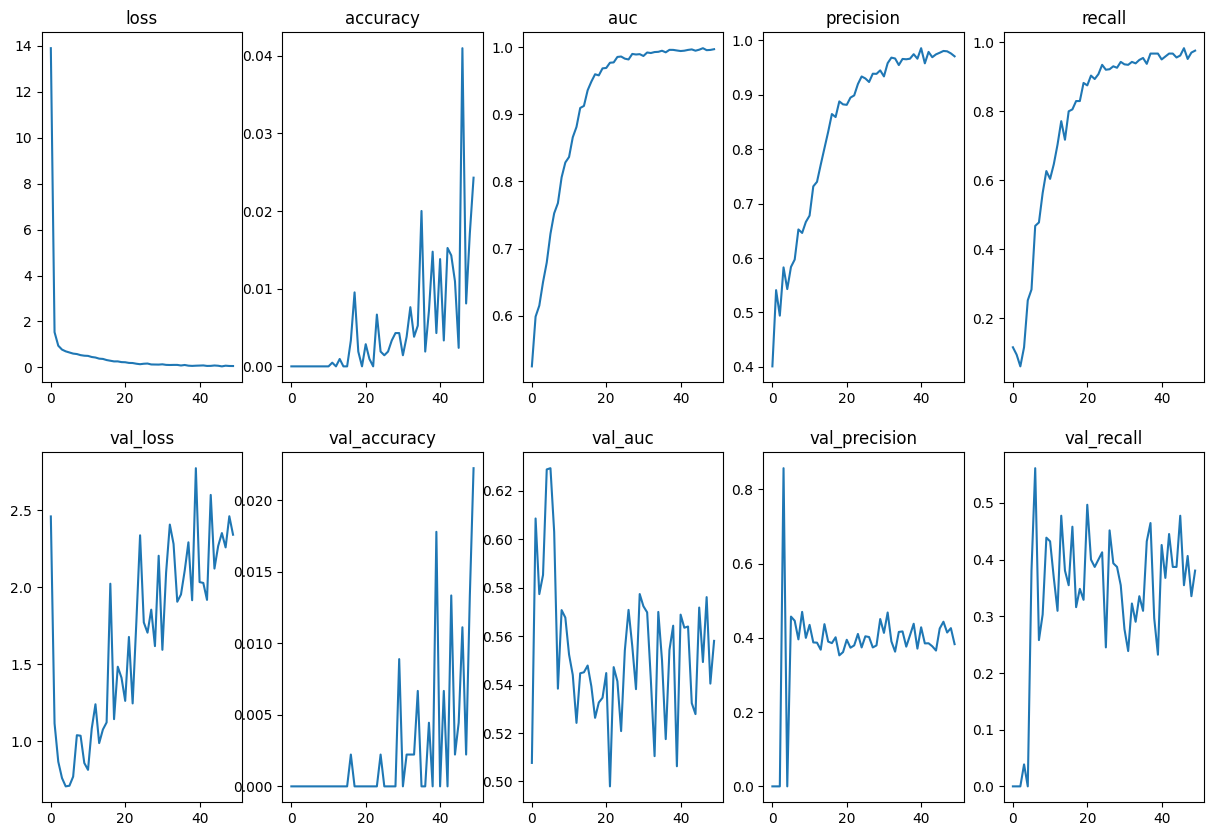

In [17]:
#Visualize model metrics during training
plot_history_metrics(trained_model.model_history)